# Credit Risk Scoring:

Imagine  that  we  work  at  a  bank.  When  we  receive  a  loan  application,  we  need  to  make sure  that  if  we  give  the  money,  the  customer  will  be  able  to  pay  it  back.  Every  application  carries  a  risk  of  default  —  the  failure  to  return  the  money.

We’d  like  to  minimize  this  risk:  before  agreeing  to  give  a  loan,  we  want  to  score  the customer  and  assess  the  chances  of  default.  If  it’s  too  high,  we  reject  the  application. This  process  is  called  *“credit  risk  scoring.”*

Machine  learning  can  be  used  for  calculating  the  risk.  For  that,  we  need  a  dataset with  loans,  where  for  each  application,  we  know  whether  or  not  it  was  paid  back  successfully.  Using  this  data,  we  can  build  a  model  for  predicting  the  probability  of  default,  and we  can  use  this  model  to  assess  the  risk  of  future  borrowers  not  repaying  the  money.

- First,  we  get  the  data  and  do  some  initial  preprocessing.
- Next,  we  train  a  decision  tree  model  from  Scikit-learn  for  predicting  the  probability  of  default.
- After  that,  we  explain  how  decision  trees  work  and  which  parameters  the  model has  and  show  how  to  adjust  these  parameters  to  get  the  best  performance.
- Then  we  combine  multiple  decision  trees  into  one  model  —  a  random  forest.  We look  at  its  parameters  and  tune  them  to  achieve  the  best  predictive  performance.
- Finally,  we  explore  a  different  way  of  combining  decision  trees  —  gradient boosting.  We  use  XGBoost,  a  highly  efficient  library  that  implements  gradient boosting.  We’ll  train  a  model  and  tune  its  parameters.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['axes.grid'] = False
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['figure.dpi'] = 200

In [ ]:
df = pd.read_csv('Credit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446 entries, 0 to 4445
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Status      4446 non-null   object 
 1   Seniority   4446 non-null   int64  
 2   Home        4446 non-null   object 
 3   Time        4446 non-null   int64  
 4   Age         4446 non-null   int64  
 5   Marital     4446 non-null   object 
 6   Records     4446 non-null   object 
 7   Job         4446 non-null   object 
 8   Expenses    4446 non-null   int64  
 9   Income      4446 non-null   int64  
 10  Assets      4446 non-null   int64  
 11  Debt        4446 non-null   int64  
 12  Amount      4446 non-null   int64  
 13  Price       4446 non-null   int64  
 14  Finrat      4446 non-null   float64
 15  Savings     4446 non-null   float64
 16  seniorityR  4446 non-null   object 
 17  timeR       4446 non-null   object 
 18  ageR        4446 non-null   object 
 19  expensesR   4446 non-null  

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price',
       'finrat', 'savings', 'seniorityr', 'timer', 'ager', 'expensesr',
       'incomer', 'assetsr', 'debtr', 'amountr', 'pricer', 'finratr',
       'savingsr'],
      dtype='object')

In [ ]:
df.rename(columns={
    'seniorityr':'seniority_range',
    'timer':'time_range',
    'ager':'age_range',
    'expensesr':'expenses_range',
    'incomer':'income_range',
    'assestsr':'assets_range',
    'debtr':'debt_range',
    'amountr':'amount_range',
    'pricer':'price_range',
    'finratr':'finrat_range',
    'savingsr':'savings_rate'
}, inplace=True)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,finrat,savings,seniority_range,time_range,age_range,expenses_range,income_range,assetsr,debt_range,amount_range,price_range,finrat_range,savings_rate
0,good,9,rent,60,30,married,no_rec,freelance,73,129,0,0,800,846,94.562648,4.200000,"sen (8,14]","time (48,99]","age (25,30]","exp (60,80]","inc (110,140]","asset (-1,0]","debt (-1,0]","am (600,900]","priz (0,1e+03]","finr (90,100]","sav (4,6]"
1,good,17,rent,60,58,widow,no_rec,fixed,48,131,0,0,1000,1658,60.313631,4.980000,"sen (14,99]","time (48,99]","age (50,99]","exp (40,50]","inc (110,140]","asset (-1,0]","debt (-1,0]","am (900,1.1e+03]","priz (1.5e+03,1.8e+03]","finr (50,70]","sav (4,6]"
2,bad,10,owner,36,46,married,yes_rec,freelance,90,200,3000,0,2000,2985,67.001675,1.980000,"sen (8,14]","time (24,36]","age (40,50]","exp (80,1e+04]","inc (190,1e+04]","asset (0,3e+03]","debt (-1,0]","am (1.4e+03,1e+05]","priz (1.8e+03,1e+05]","finr (50,70]","sav (0,2]"
3,good,0,rent,60,24,single,no_rec,fixed,63,182,2500,0,900,1325,67.924528,7.933333,"sen (-1,1]","time (48,99]","age (0,25]","exp (60,80]","inc (140,190]","asset (0,3e+03]","debt (-1,0]","am (600,900]","priz (1.3e+03,1.5e+03]","finr (50,70]","sav (6,99]"
4,good,0,rent,36,26,single,no_rec,fixed,46,107,0,0,310,910,34.065934,7.083871,"sen (-1,1]","time (24,36]","age (25,30]","exp (40,50]","inc (80,110]","asset (-1,0]","debt (-1,0]","am (0,600]","priz (0,1e+03]","finr (0,50]","sav (6,99]"


In [ ]:
status_encoded = {'good':'ok',
                  'bad':'default'}
df['status'] = df['status'].map(status_encoded)
df['status'].value_counts()

ok         3197
default    1249
Name: status, dtype: int64

In [ ]:
home_encoded = {'owner':'owner','rent':'rent',
                'parents':'parents','priv':'priv',
                'other':'others', 'ignore':'others'}
df['home'] = df['home'].apply(lambda x: home_encoded[x])
df['home'].value_counts()

owner      2106
rent        973
parents     782
others      339
priv        246
Name: home, dtype: int64

In [ ]:
df.describe()

,seniority,time,age,expenses,income,assets,debt,amount,price,finrat,savings
count,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000,4446.000000
mean,7.991453,46.453441,37.084121,55.601439,140.629780,5354.948943,342.257085,1038.763383,1462.480432,72.616409,3.860083
std,8.176370,14.647979,10.986366,19.520839,80.177896,11534.328183,1244.694549,474.747952,628.555171,20.390595,3.726292
min,0.000000,6.000000,18.000000,35.000000,1.000000,0.000000,0.000000,100.000000,105.000000,6.702413,-8.160000
25%,2.000000,36.000000,28.000000,35.000000,90.000000,0.000000,0.000000,700.000000,1116.250000,60.030020,1.615385
50%,5.000000,48.000000,36.000000,51.000000,124.000000,3000.000000,0.000000,1000.000000,1400.000000,77.096757,3.120000
75%,12.000000,60.000000,45.000000,72.000000,170.000000,6000.000000,0.000000,1300.000000,1691.500000,88.460263,5.195688
max,48.000000,72.000000,68.000000,180.000000,959.000000,300000.000000,30000.000000,5000.000000,11140.000000,100.000000,33.250000


# Exploratory Data Analysis:

In [ ]:
colors = ['#7db1b1','#bf263c','#e0c341',
          '#6a50a7','#b3b3b3','#323133']


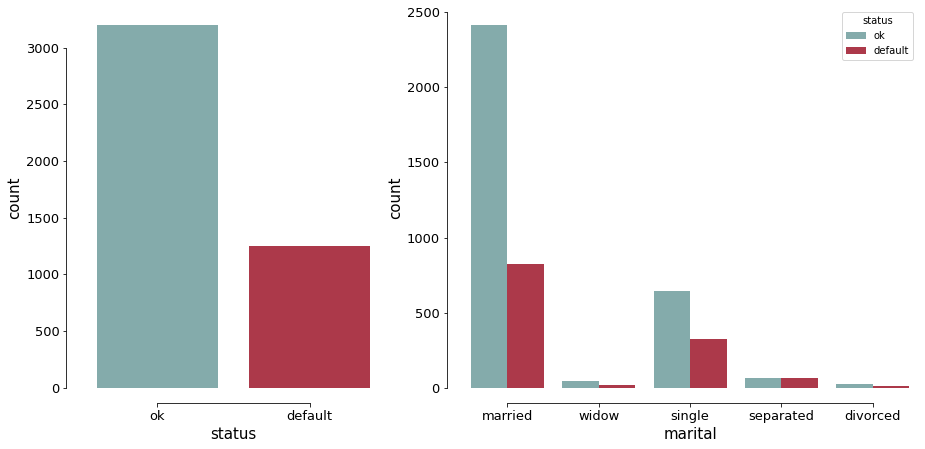

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,
            figsize=(15,7), gridspec_kw={
                'width_ratios':(.4,0.6)
            })
sns.countplot(data=df, x='status', palette=colors[:2], 
              ax=ax[0], order=['ok','default'])
sns.countplot(data=df, x='marital', hue='status',
              hue_order=['ok','default'], ax=ax[1],
              palette=colors[:5])
sns.despine(offset=15, trim=True)

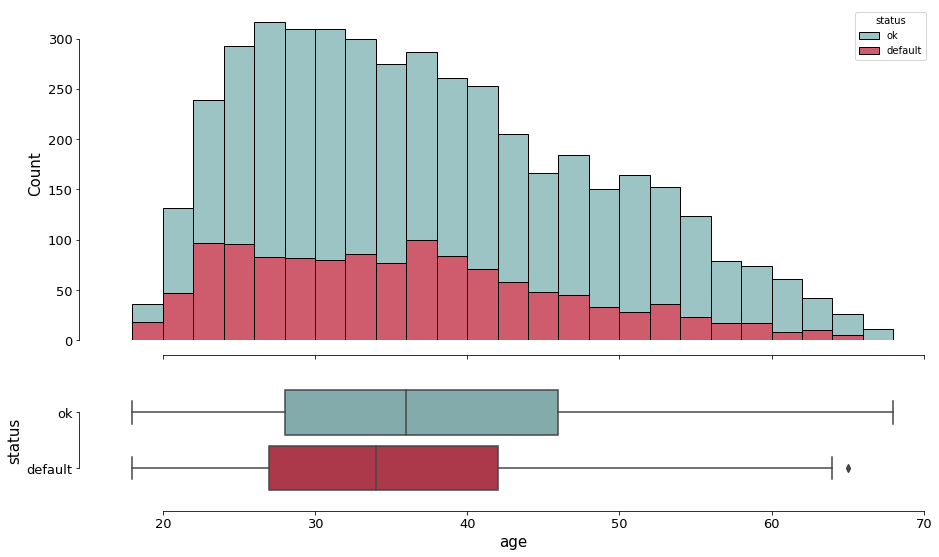

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,
            figsize=(15,9), gridspec_kw={
                'height_ratios':(.75,.25)
            })
sns.histplot(data=df, x='age', hue='status', 
             palette=colors[:2], hue_order=['ok','default'],
             multiple='stack', ax=ax[0])
sns.boxplot(data=df, x='age', y='status', 
            palette=colors[:2], ax=ax[1])
sns.despine(offset=15, trim=True)
plt.show()

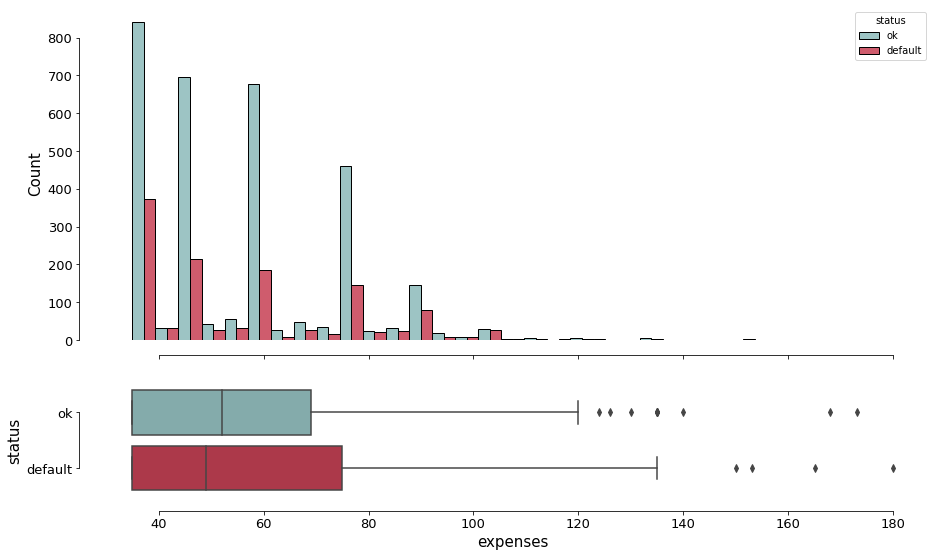

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,
            figsize=(15,9), gridspec_kw={
                'height_ratios':(.75,.25)
            })
sns.histplot(data=df, x='expenses', hue='status', 
             palette=colors[:2], hue_order=['ok','default'],
             multiple='dodge', ax=ax[0])
sns.boxplot(data=df, x='expenses', y='status', 
            palette=colors[:2], ax=ax[1])
sns.despine(offset=15, trim=True)
plt.show()

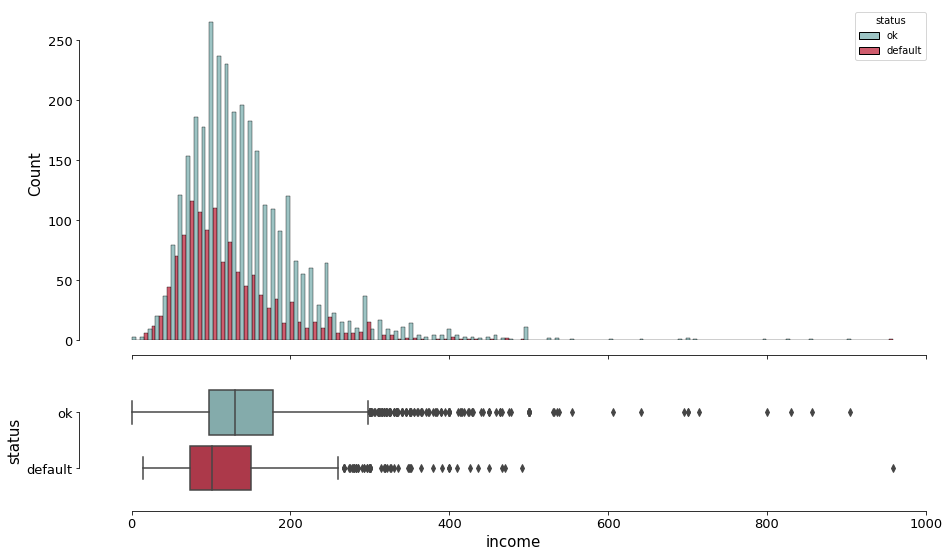

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,
            figsize=(15,9), gridspec_kw={
                'height_ratios':(.75,.25)
            })
sns.histplot(data=df, x='income', hue='status', 
             palette=colors[:2], hue_order=['ok','default'],
             multiple='dodge', ax=ax[0])
sns.boxplot(data=df, x='income', y='status', 
            palette=colors[:2], ax=ax[1])
sns.despine(offset=15, trim=True)
plt.show()

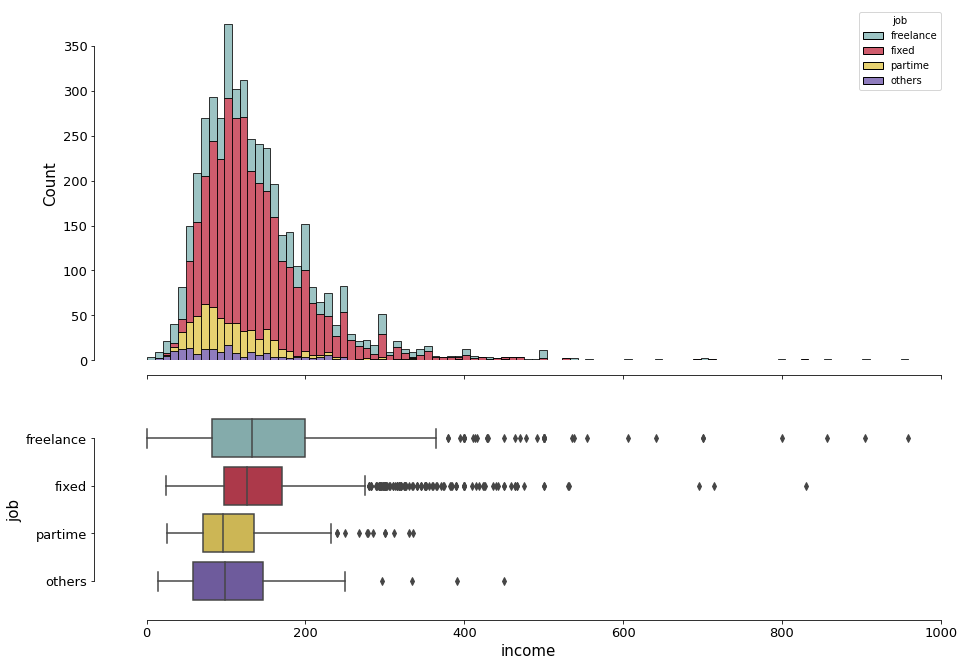

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,
            figsize=(15,11), gridspec_kw={
                'height_ratios':(.65,.35)
            })
sns.histplot(data=df, x='income', hue='job', 
             palette=colors[:4],
             multiple='stack', ax=ax[0])
sns.boxplot(data=df, x='income', y='job', 
            palette=colors[:4], ax=ax[1])
sns.despine(offset=15, trim=True)
plt.show()

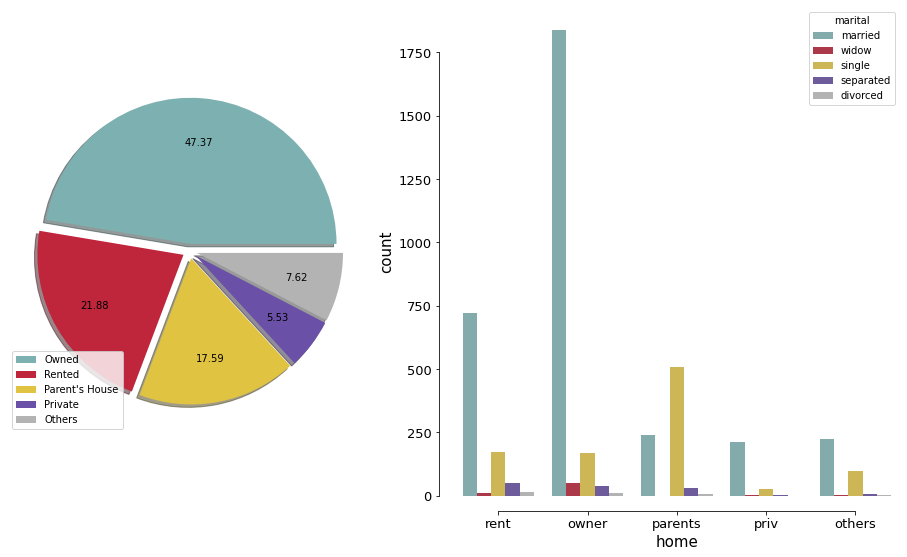

In [ ]:
owned = df['home'].value_counts()['owner']
rented = df['home'].value_counts()['rent']
parents = df['home'].value_counts()['parents']
private = df['home'].value_counts()['priv']
others = df['home'].value_counts()['others']

vals = [owned, rented, parents, private, others]
names = ['Owned','Rented', "Parent's House", 'Private','Others']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9),
                       gridspec_kw=
                {'width_ratios':(0.45,0.55)})
ax[0].pie(x=vals,
          colors=colors[:5], pctdistance=0.7,
            autopct='%.2f', shadow=True,
            explode=(0.05,0.05,0.05,0.05,0.05))
ax[0].legend(names, loc='lower left')
sns.countplot(data=df, x='home', hue='marital',
              palette=colors[:5])
sns.despine(offset=15, trim=True)
plt.show()

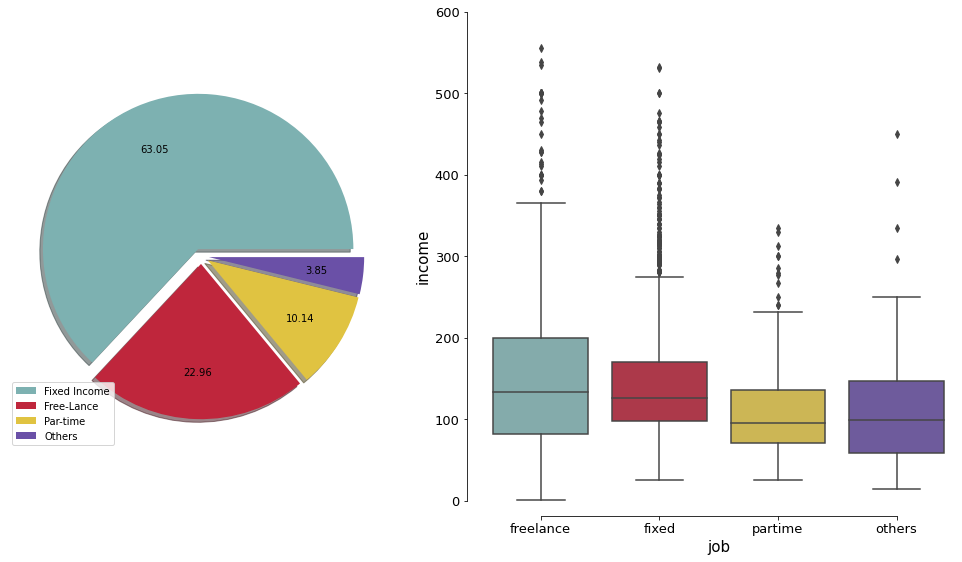

In [ ]:
fixed = df['job'].value_counts()[0]
freelance = df['job'].value_counts()[1]
partime = df['job'].value_counts()[2]
others = df['job'].value_counts()[3]

vals = [fixed, freelance, partime, others]
names = ['Fixed Income', 'Free-Lance','Par-time','Others']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17,9),
            gridspec_kw={
               'width_ratios':(0.45,0.55)
                       })
ax[0].pie(x=vals, colors=colors[:4], pctdistance=0.7,
            autopct='%.2f', shadow=True,
            explode=(0.05,0.05,0.05,0.05))
ax[0].legend(names, loc='lower left')
sns.boxplot(data=df, x='job', y='income', palette=colors[:4],
            ax=ax[1])
ax[1].set_ylim([0,600])
sns.despine(offset=15, trim=True)
plt.show()

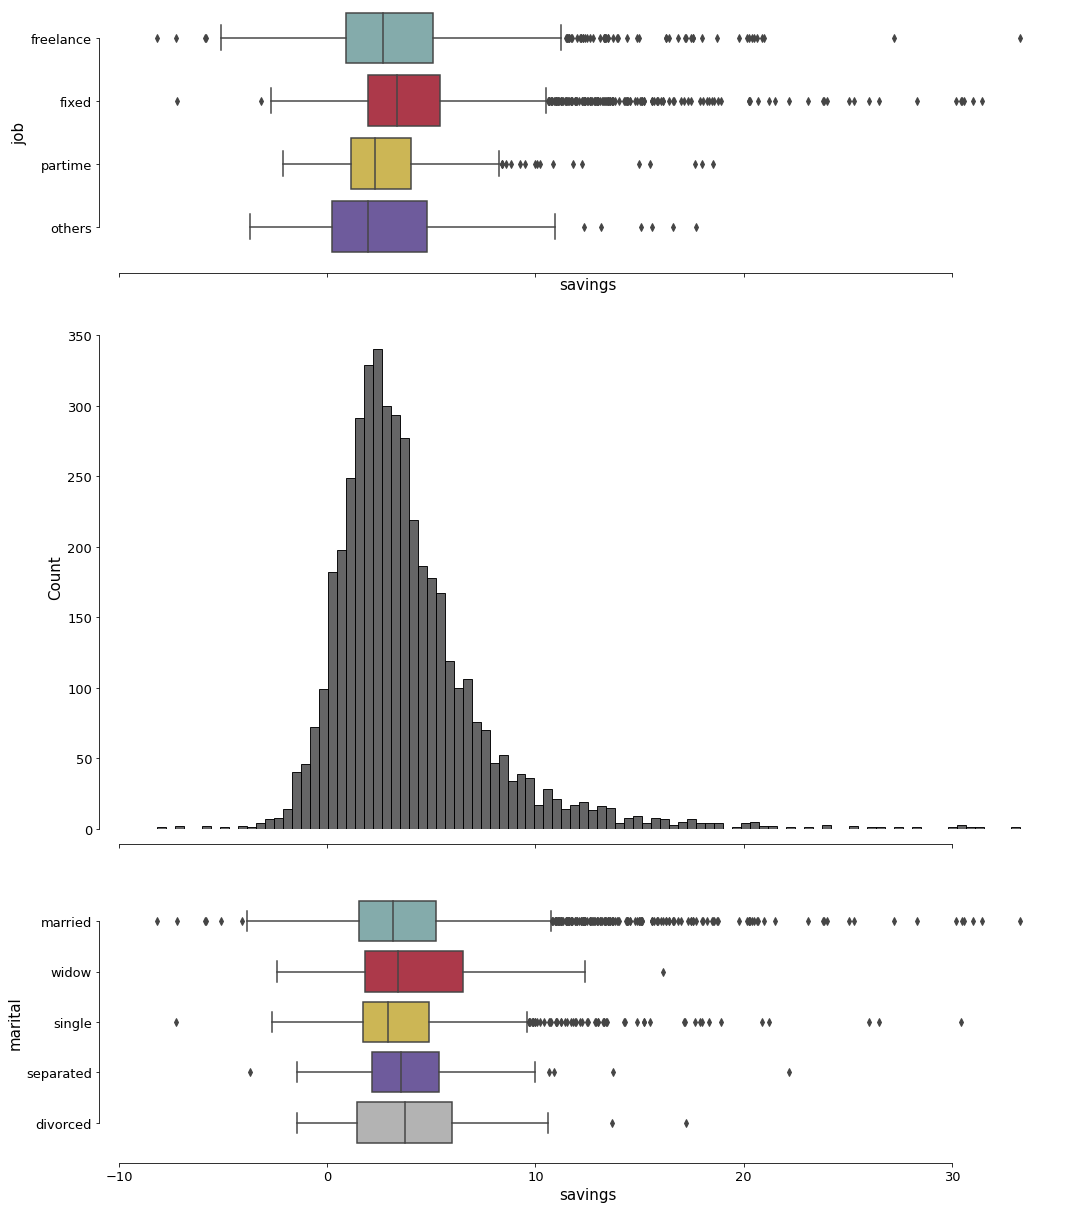

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True,
            figsize=(17,21), gridspec_kw={
                'height_ratios':(.25,.5,.25)
            })
sns.boxplot(data=df, x='savings', y='job', palette=colors[:4],
            ax=ax[0])
sns.histplot(data=df, x='savings', 
             color='#323133', ax=ax[1])
sns.boxplot(data=df, x='savings', y='marital', 
            palette=colors[:5], ax=ax[2])
sns.despine(offset=15, trim=True)
plt.show()

# Machine Learning - Dataset Preparation:

In [ ]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(
    df, test_size=0.2, random_state=11
)

df_train, df_val = train_test_split(
    df_train_full, test_size=0.25, random_state=11
)

In [ ]:
len(df_train), len(df_val), len(df_test)

(2667, 889, 890)

In [ ]:
y_train = (df_train['status']=='default').values
y_val =  (df_val['status']=='default').values

In [ ]:
del df_train['status']
del df_val['status']

In [ ]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [ ]:
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

In [ ]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

# Machine Learning - Decision Tree:


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:,1]
print(f'Training Score :{roc_auc_score(y_train, y_pred)}')

Training Score :1.0


In [ ]:
y_pred = dt.predict_proba(X_val)[:,1]
print(f'Validation Score: \
{roc_auc_score(y_val, y_pred):.2f}')

Validation Score: 0.65


We observe a case  of  overfitting. The  tree  learned  the  training  data  so  well  that it  simply  memorized  the  outcome  for  each  customer.  However,  when  we  applied  it  to the  validation  set,  the  model  failed.  The  rules  it  extracted  from  the  data  turned  out  to be  too  specific  to  the  training  set,  so  it  worked  poorly  for  customers  it  didn’t  see during  training.

In [ ]:
from sklearn.tree import export_text

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

tree_text = export_text(dt, 
            feature_names= dv.feature_names_)
print(tree_text)

|--- records=yes_rec <= 0.50
|   |--- seniority <= 2.50
|   |   |--- class: False
|   |--- seniority >  2.50
|   |   |--- class: False
|--- records=yes_rec >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



In [ ]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print(f'Area Under the Curve of Training: \
{(auc):.2}')
y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred) 
print(f'Area Under the Curve of Validation: \
{(auc):.2f}')

Area Under the Curve of Training: 0.71
Area Under the Curve of Validation: 0.74


Previously,  the  performance  on  the  training  set  was  100%,  but  now  it’s  only  71%.  It means  that  the  model  can  no  longer  memorize  all  the  outcomes  from  the  training  set. However,  the  score  on  the  validation  set  is  better:  it’s  74%,  which  is  an  improvement  over  the  previous  result  (65%).  By  making  it  less  complex,  we  improved  the ability  of  our  model  to  generalize.  Now  it’s  better  at  predicting  the  outcomes  for  customers  it  hasn’t  seen  previously.

However,  this  tree  has  another  problem  —  it’s  too  simple.  To  make  it  better,  we need  to  tune  the  model:  try  different  parameters,  and  see  which  ones  lead  to  the  best AUC. In addition  to  max_depth,  we  can  control  other  parameters.  To  understand  what these  parameters  mean  and  how  they  influence  the  model,  let’s  take  a  step  back  and look  at  how  decision  trees  learn  rules  from  data.

## Parameter Tuning for Decision Tree:

In [ ]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.631
   2 -> 0.742
   3 -> 0.788
   4 -> 0.793
   5 -> 0.790
   6 -> 0.771
  10 -> 0.687
  15 -> 0.664
  20 -> 0.639
None -> 0.649


In [ ]:
for m in [4,5,6]:
    print('depth: %s' %m)

    for s in [1,5,10,15,20,50,100,200]:
        dt = DecisionTreeClassifier(
            max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    print()

depth: 4
1 -> 0.793
5 -> 0.790
10 -> 0.790
15 -> 0.794
20 -> 0.795
50 -> 0.801
100 -> 0.797
200 -> 0.790

depth: 5
1 -> 0.790
5 -> 0.785
10 -> 0.788
15 -> 0.792
20 -> 0.795
50 -> 0.799
100 -> 0.801
200 -> 0.793

depth: 6
1 -> 0.771
5 -> 0.787
10 -> 0.790
15 -> 0.784
20 -> 0.794
50 -> 0.806
100 -> 0.808
200 -> 0.793



The best **AUC** is **80.8** with min_samples_leaf = 100 and max_depth=6.

In [ ]:
dt = DecisionTreeClassifier(max_depth=6,
                    min_samples_leaf=100)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:,1]
print(f'Training Score :\
{roc_auc_score(y_train, y_pred):.3f}')

y_pred = dt.predict_proba(X_val)[:,1]
print(f'Validation Score: \
{roc_auc_score(y_val, y_pred):.2f}')

Training Score :0.807
Validation Score: 0.80


# Random Forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, 
            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [ ]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8132300469483569

In [ ]:
aucs = []

for x in range(10,201,10):
    rf = RandomForestClassifier(
        n_estimators=x, random_state=1
    )
    rf.fit(X_train,y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (x, auc))
    aucs.append(auc)

10 -> 0.813
20 -> 0.833
30 -> 0.845
40 -> 0.850
50 -> 0.854
60 -> 0.856
70 -> 0.856
80 -> 0.857
90 -> 0.857
100 -> 0.858
110 -> 0.861
120 -> 0.861
130 -> 0.860
140 -> 0.860
150 -> 0.860
160 -> 0.860
170 -> 0.860
180 -> 0.860
190 -> 0.859
200 -> 0.860


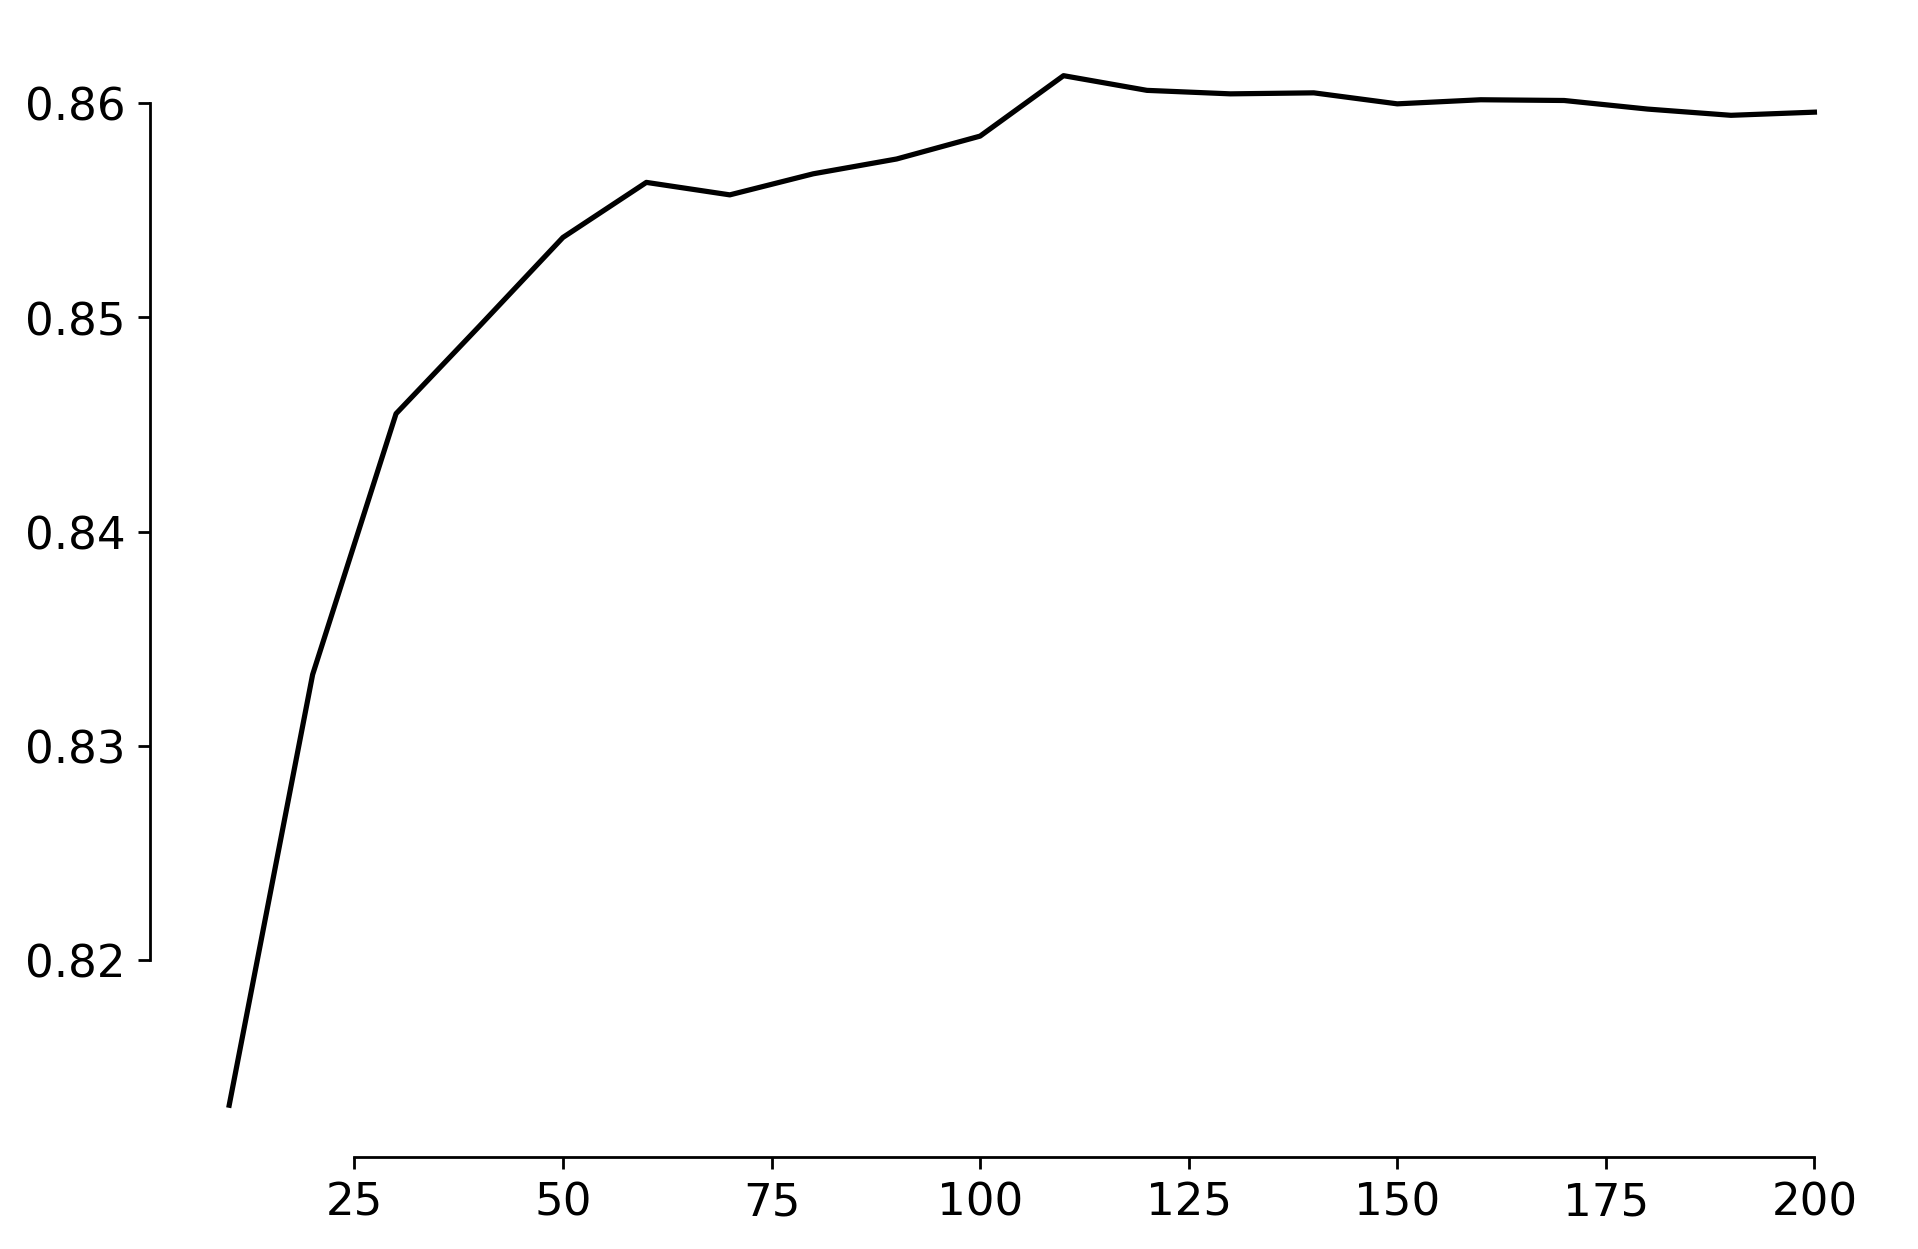

In [ ]:
plt.figure(figsize=(9,6), dpi=250)
plt.plot(range(10,201,10), aucs, 
         color='black')
sns.despine(trim=True)
plt.show()

## Parameter Tuning for Random Forest:

In [ ]:
all_aucs = {}

for depth in [5,10,20,50]:
    print('depth: %s' % depth)
    aucs = []

    for x in range(10,201,10):
        rf = RandomForestClassifier(
            n_estimators=x, max_depth=depth,
            random_state=1
        )
        rf.fit(X_train,y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (x, auc))
        aucs.append(auc)

    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.842
20 -> 0.852
30 -> 0.856
40 -> 0.854
50 -> 0.855
60 -> 0.856
70 -> 0.857
80 -> 0.858
90 -> 0.857
100 -> 0.857
110 -> 0.858
120 -> 0.858
130 -> 0.858
140 -> 0.858
150 -> 0.857
160 -> 0.856
170 -> 0.856
180 -> 0.857
190 -> 0.857
200 -> 0.857

depth: 10
10 -> 0.823
20 -> 0.840
30 -> 0.846
40 -> 0.851
50 -> 0.854
60 -> 0.855
70 -> 0.854
80 -> 0.856
90 -> 0.857
100 -> 0.856
110 -> 0.856
120 -> 0.857
130 -> 0.857
140 -> 0.856
150 -> 0.856
160 -> 0.857
170 -> 0.857
180 -> 0.857
190 -> 0.857
200 -> 0.858

depth: 20
10 -> 0.802
20 -> 0.830
30 -> 0.843
40 -> 0.848
50 -> 0.851
60 -> 0.854
70 -> 0.855
80 -> 0.856
90 -> 0.856
100 -> 0.855
110 -> 0.858
120 -> 0.858
130 -> 0.858
140 -> 0.858
150 -> 0.858
160 -> 0.859
170 -> 0.859
180 -> 0.859
190 -> 0.860
200 -> 0.860

depth: 50
10 -> 0.813
20 -> 0.833
30 -> 0.845
40 -> 0.850
50 -> 0.854
60 -> 0.856
70 -> 0.856
80 -> 0.857
90 -> 0.857
100 -> 0.858
110 -> 0.861
120 -> 0.861
130 -> 0.860
140 -> 0.860
150 -> 0.860
160 -> 0.860
170 ->

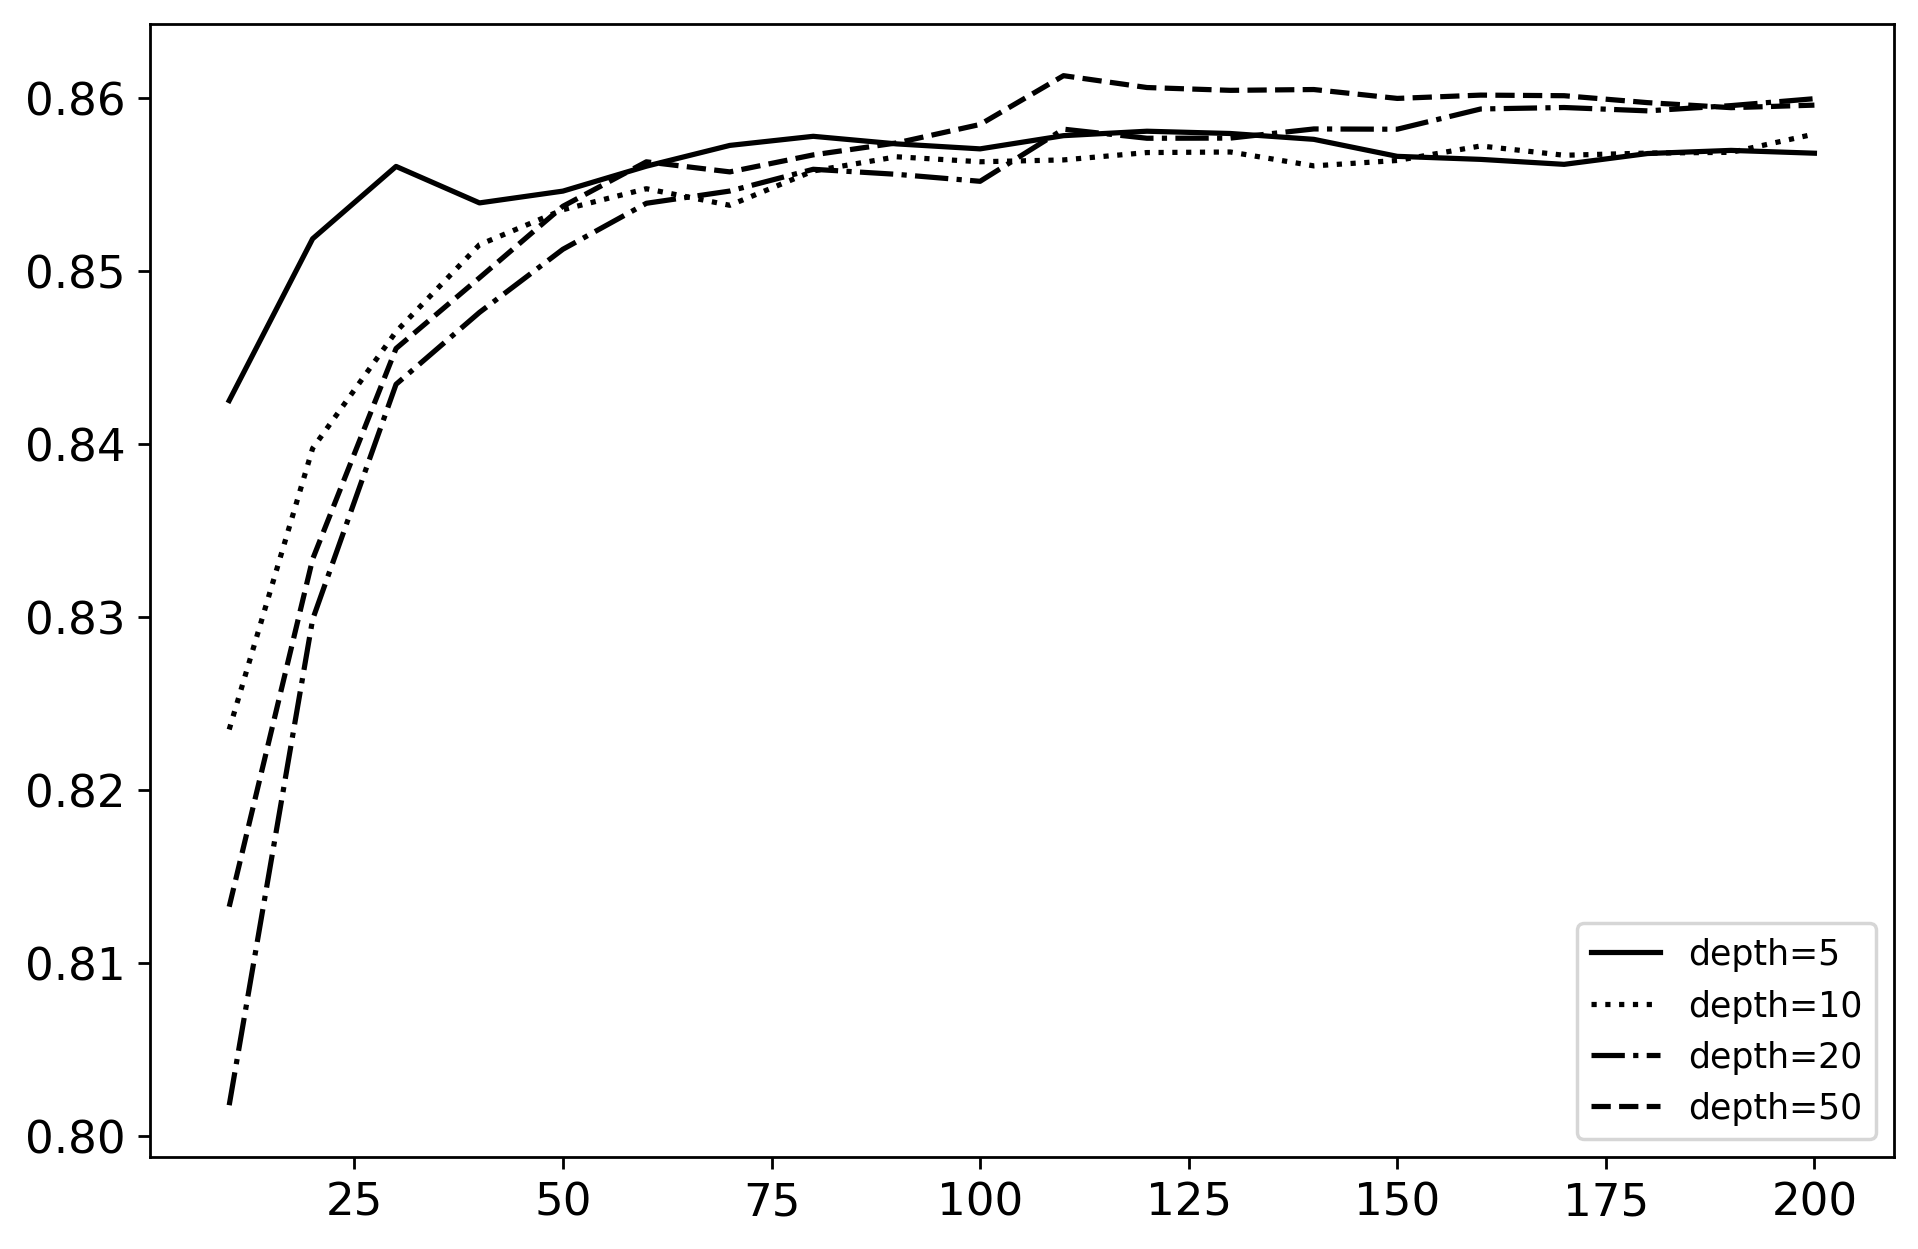

In [ ]:
num_trees = list(range(10,201,10))

plt.figure(figsize=(9,6), dpi=250)
plt.plot(num_trees, all_aucs[5], 
         label='depth=5', color='black')
plt.plot(num_trees, all_aucs[10], 
         label='depth=10', color='black',
         linestyle='dotted')
plt.plot(num_trees, all_aucs[20], 
         label='depth=20', color='black',
         linestyle='dashdot')
plt.plot(num_trees, all_aucs[50], 
         label='depth=50', color='black',
         linestyle='dashed')
plt.legend()
plt.show()

In [ ]:
all_aucs = {}
for m in [3,5,10,20]:
    print('min_samples_leaf: %s' %m)
    aucs = []

    for x in range(10,201,10):
        rf = RandomForestClassifier(
            n_estimators=x, max_depth=50,
            min_samples_leaf=m, random_state=1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' %(x, auc))
        aucs.append(auc)

    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.833
20 -> 0.848
30 -> 0.852
40 -> 0.853
50 -> 0.854
60 -> 0.857
70 -> 0.857
80 -> 0.858
90 -> 0.858
100 -> 0.857
110 -> 0.858
120 -> 0.857
130 -> 0.857
140 -> 0.857
150 -> 0.857
160 -> 0.857
170 -> 0.856
180 -> 0.857
190 -> 0.857
200 -> 0.857

min_samples_leaf: 5
10 -> 0.830
20 -> 0.838
30 -> 0.846
40 -> 0.848
50 -> 0.851
60 -> 0.854
70 -> 0.854
80 -> 0.856
90 -> 0.857
100 -> 0.859
110 -> 0.858
120 -> 0.859
130 -> 0.859
140 -> 0.859
150 -> 0.860
160 -> 0.860
170 -> 0.859
180 -> 0.858
190 -> 0.859
200 -> 0.860

min_samples_leaf: 10
10 -> 0.845
20 -> 0.853
30 -> 0.855
40 -> 0.859
50 -> 0.860
60 -> 0.862
70 -> 0.862
80 -> 0.864
90 -> 0.863
100 -> 0.863
110 -> 0.864
120 -> 0.864
130 -> 0.864
140 -> 0.863
150 -> 0.863
160 -> 0.862
170 -> 0.862
180 -> 0.862
190 -> 0.862
200 -> 0.863

min_samples_leaf: 20
10 -> 0.848
20 -> 0.851
30 -> 0.855
40 -> 0.858
50 -> 0.856
60 -> 0.859
70 -> 0.860
80 -> 0.860
90 -> 0.859
100 -> 0.859
110 -> 0.859
120 -> 0.859
130 -> 0.859
14

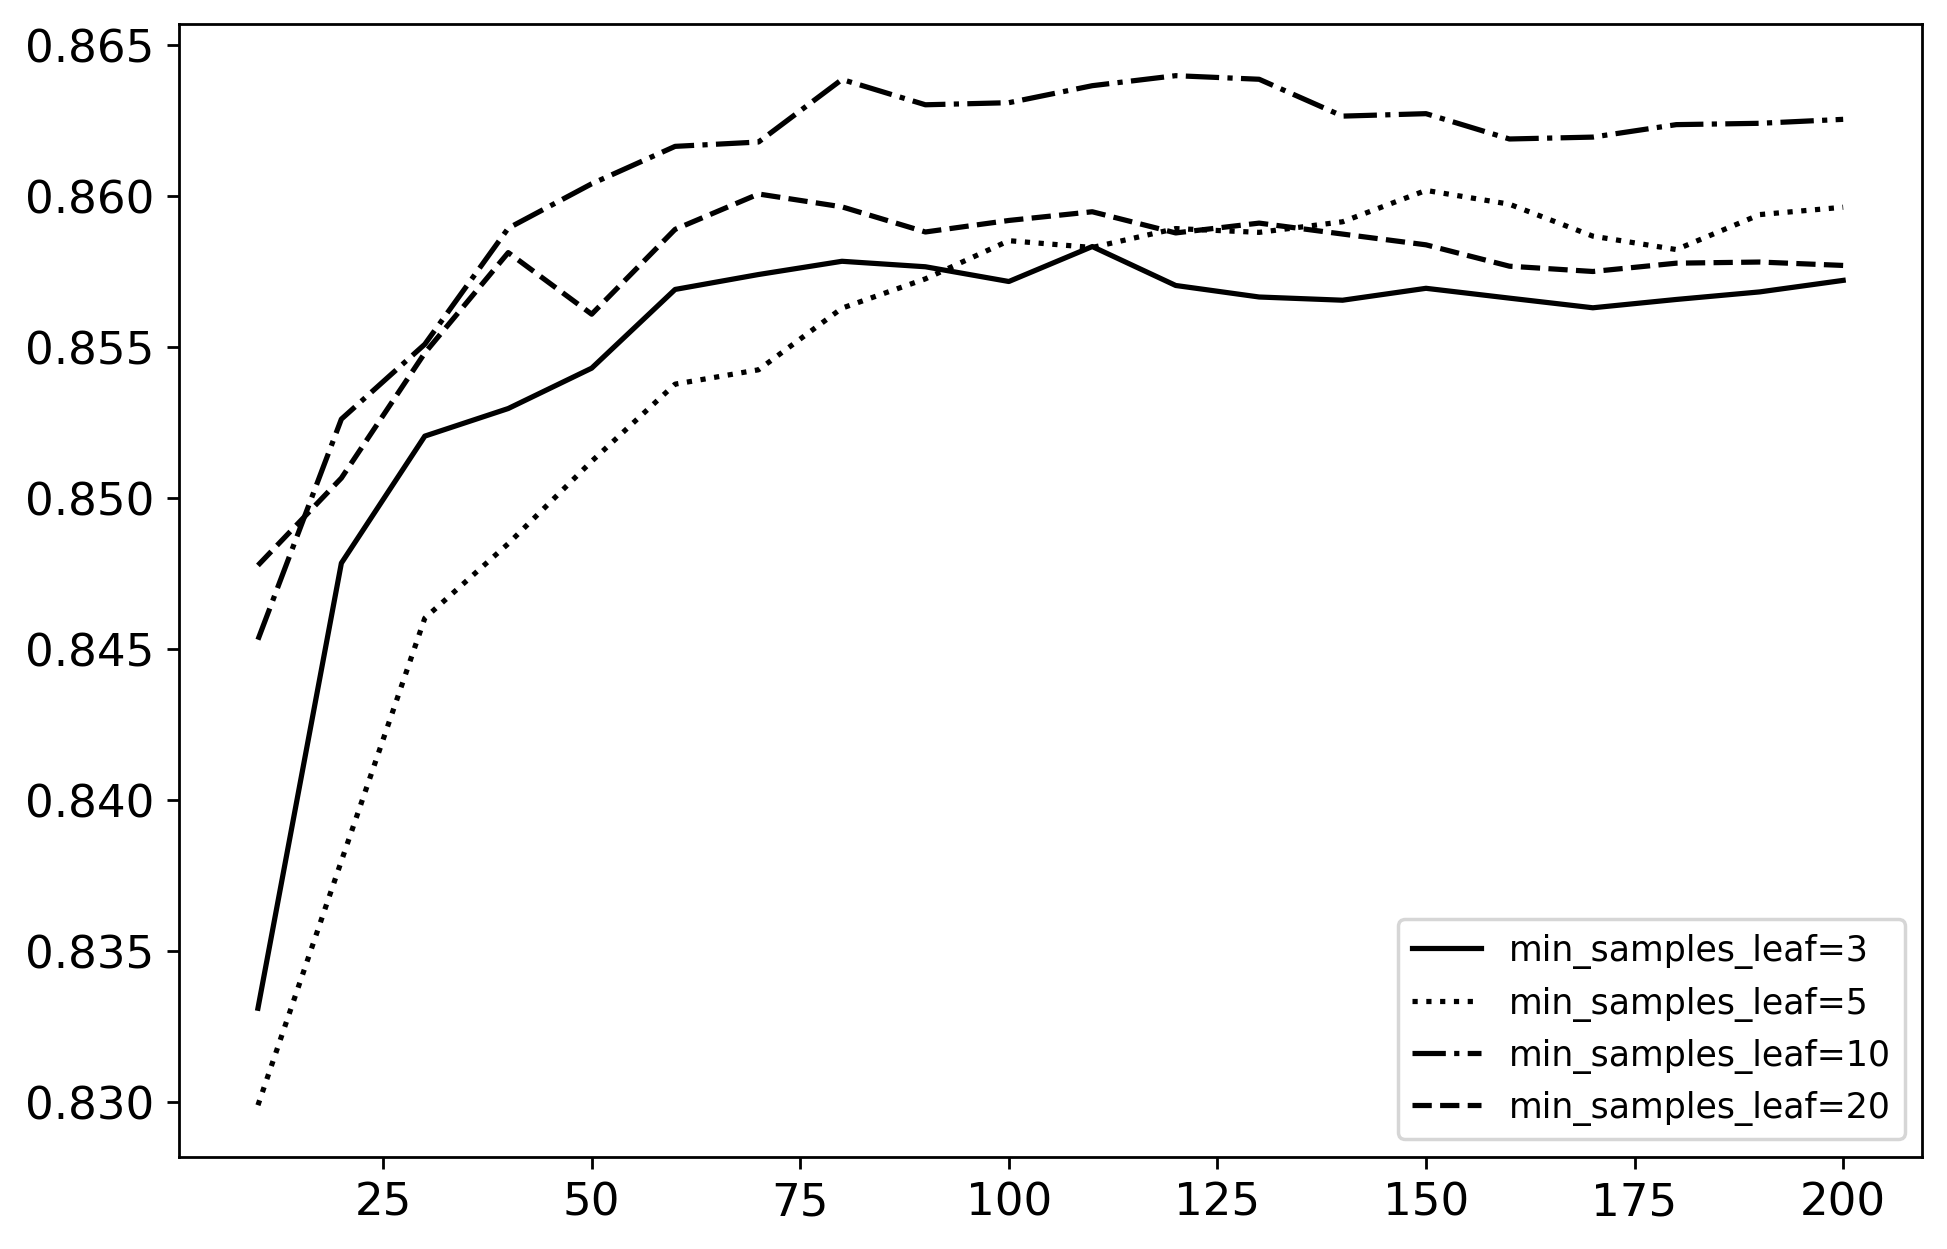

In [ ]:
num_trees = list(range(10,201,10))

plt.figure(figsize=(9,6), dpi=250)
plt.plot(num_trees, all_aucs[3], 
         label='min_samples_leaf=3', color='black')
plt.plot(num_trees, all_aucs[5], 
         label='min_samples_leaf=5', color='black',
         linestyle='dotted')
plt.plot(num_trees, all_aucs[10], 
         label='min_samples_leaf=10', color='black',
         linestyle='dashdot')
plt.plot(num_trees, all_aucs[20], 
         label='min_samples_leaf=20', color='black',
         linestyle='dashed')
plt.legend()
plt.show()

# Gradient Boosting:

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'nthread':8,
    'seed':1,
    'silent':1
}
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=10)
y_pred = model.predict(dval)
y_pred[:10]

array([0.19936605, 0.36500043, 0.06880373, 0.07192294, 0.21881178,
       0.16327874, 0.24418871, 0.7277644 , 0.76796   , 0.11026128],
      dtype=float32)

In [ ]:
roc_auc_score(y_val, y_pred)

0.839661971830986

## Model Performance Monitoring:

In [ ]:
watchlist = [(dtrain, 'train'), (dval,'val')]

xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'silent':1
}
model = xgb.train(xgb_params, dtrain,
            num_boost_round=100, 
            evals=watchlist, verbose_eval=10)

[0]	train-auc:0.851744	val-auc:0.777239
[10]	train-auc:0.956018	val-auc:0.839393
[20]	train-auc:0.980369	val-auc:0.833352
[30]	train-auc:0.990733	val-auc:0.832795
[40]	train-auc:0.996013	val-auc:0.831518
[50]	train-auc:0.998355	val-auc:0.833484
[60]	train-auc:0.999408	val-auc:0.832626
[70]	train-auc:0.999875	val-auc:0.831105
[80]	train-auc:0.999968	val-auc:0.830986
[90]	train-auc:0.999996	val-auc:0.832707
[99]	train-auc:0.999999	val-auc:0.828426


This  behavior  is  expected:  in  boosting,  every  next  model  tries  to  fix  the  mistakes  from the  previous  step,  so  the  score  is  always  improving. For  the  validation  score,  however,  this  is  not  the  case.  It  goes  up  initially  but  then starts  to  decrease.  This  is  the  effect  of  overfitting:  our  model  becomes  more  and  more complex  until  it  simply  memorizes  the  entire  training  set.  It’s  not  helpful  for  predicting  the  outcome  for  the  customers  outside  of  the  training  set,  and  the  validation  score reflects  that. We  get  the  best  AUC  on  the  10th  iteration  (83.9%)

## Parameter Tuning For XGBoost:

In [ ]:
xgb_params = {
    'eta':0.1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'silent':1
}
model = xgb.train(xgb_params,dtrain,
            num_boost_round=500,
            evals=watchlist, verbose_eval=10)


[0]	train-auc:0.851744	val-auc:0.777239
[10]	train-auc:0.924042	val-auc:0.835743
[20]	train-auc:0.944777	val-auc:0.843011
[30]	train-auc:0.958886	val-auc:0.842736
[40]	train-auc:0.967255	val-auc:0.843825
[50]	train-auc:0.97492	val-auc:0.842879
[60]	train-auc:0.981142	val-auc:0.844207
[70]	train-auc:0.985675	val-auc:0.845878
[80]	train-auc:0.988709	val-auc:0.844895
[90]	train-auc:0.990691	val-auc:0.84251
[100]	train-auc:0.992685	val-auc:0.841315
[110]	train-auc:0.994196	val-auc:0.840632
[120]	train-auc:0.995598	val-auc:0.839549
[130]	train-auc:0.996764	val-auc:0.841083
[140]	train-auc:0.99779	val-auc:0.838917
[150]	train-auc:0.998309	val-auc:0.838128
[160]	train-auc:0.998809	val-auc:0.838103
[170]	train-auc:0.99915	val-auc:0.837728
[180]	train-auc:0.999413	val-auc:0.838097
[190]	train-auc:0.999557	val-auc:0.838228
[200]	train-auc:0.999699	val-auc:0.837959
[210]	train-auc:0.999814	val-auc:0.838247
[220]	train-auc:0.999877	val-auc:0.837565
[230]	train-auc:0.999931	val-auc:0.836407
[240]	t

## Testing the Final Model:

In [ ]:
y_train = (df_train_full['status']=='default').values
y_test = (df_test['status']=='default').values


del df_train_full['status']
del df_test['status']

In [ ]:
dict_train = df_train_full.fillna(
    0).to_dict(orient='records')
dict_test = df_test.fillna(
    0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'eta':0.1,
    'max_depth':3,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'silent':1
}
num_trees = 160
model = xgb.train(xgb_params, dtrain, 
            num_boost_round=num_trees)


In [ ]:
y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

0.8304699791909861

The  output  is  83%,  which  is  comparable  to  83.6%  —  the  performance  on  the  validation  set.  It  means  that  our  model  doesn’t  overfit  and  can  work  well  with  customers  it hasn’t  seen.